# Dataset

Frame is a message schema written in Proto3 syntax that is used to represent a frame containing data from multiple cameras and lidars. It is written in a format that can be easily parsed and manipulated using Python.

## Format


### Frame:

- **id** *(string)*: A unique identifier for the frame
- **cameras** *(list of Camera Object)*: contains data from multiple cameras
- **lidars** *(list of Lidar Object)*: contains data from multiple lidars

### Camera:

- **data** *(bytes fiel)*: the raw image data from the camera
- **width** *(int32 field)*: the width of the image in pixels
- **height** *(int32 field)*: the height of the image in pixels
- **depth** *(int32 field)*: the number of channels in the image (e.g. 3 for RGB)
- **T** *(list of float field)*: a list of transformation values that specify the camera's position and orientation in space, relative to the vehicle, presented as a flattened vector. The transformation matrix is traditionally given as follows:

    $$
    \mathbf{T} = 
    \begin{bmatrix}
    R_{00} & R_{01} & R_{02} & t_x\\
    R_{10} & R_{11} & R_{12} & t_y\\
    R_{20} & R_{21} & R_{22} & t_z\\
    0 & 0 & 0 & 1\\
    \end{bmatrix}
    $$

    In this matrix, $R_{ij}$ elements represent the rotation matrix and $t_x$, $t_y$, $t_z$ denote the translation components along the x, y, and z axes, respectively.

- **K** *(list of float field)*: a list of camera calibration values, provided as a flattened vector. Typically, these parameters are represented in matrix form in the literature, as shown below:

    $$
    \mathbf{K} = 
    \begin{bmatrix}
    f_x & 0 & c_x \\
    0 & f_y & c_y \\
    0 & 0 & 1
    \end{bmatrix}
    $$

    Where $f_x$ and $c_x$ denote the focal length and the principal point coordinates of the camera along the x-axis, respectively. Similarly, $f_y$ and $c_y$ represent the focal length and the principal point coordinates along the y-axis

- **D** *(list of float field)*: a list of the Distortion values of the image.
- **pos** *(Position message field)*: a Position enum value that describes the position of the camera relative to the vehicle
- **detections** *(list of CameraDetection field)*: contains a list of CameraDetection messages, each of which represents an object detection within the camera's view
- **timestamp** (float): contains the timestamp in epochs of the time when the image was recorded.

### CameraDetection:

- **id** *(string field)*: a unique identifier for the detected object
- **type** *(ObjectType field)*: an ObjectType enum value that indicates the type of object detected
- **bbox** *(list of float field)*: a list of four floating-point values that define the bounding box coordinates for a detected object within the image. These values represent the center coordinates (x0, y0) and the dimensions (width, height) of the bounding box in the image.

### Lidar:

- **data** *(list of float field)*: a list of raw lidar data points
- **width** *(int32 field)*: the number of horizontal points in the lidar scan
- **height** *(int32 field)*: the number of vertical points in the lidar scan
- **channels** *(int32 field)*: the number of channels in each lidar point (e.g. 3 for x, y, z coordinates)
- **T** *(list of float field)*: a list of transformation values that specify the lidar's position and orientation in space, relative to the vehicle, presented as a flattened vector. The transformation matrix is traditionally given as follows:

    $$
    \mathbf{T} = 
    \begin{bmatrix}
    R_{00} & R_{01} & R_{02} & t_x\\
    R_{10} & R_{11} & R_{12} & t_y\\
    R_{20} & R_{21} & R_{22} & t_z\\
    0 & 0 & 0 & 1\\
    \end{bmatrix}
    $$
    
    In this matrix, $R_{ij}$ elements represent the rotation matrix and $t_x$, $t_y$, $t_z$ denote the translation components along the x, y, and z axes, respectively.

- **pos** *(Position message field)*: a Position enum value that describes the position of the lidar relative to the vehicle
- **detections** *(list of LidarDetection field)*: contains a list of LidarDetection messages, each of which represents an object detection within the lidar's range
- **timestamp** (float): contains the timestamp in epochs of the time when the image was recorded.

### LidarDetection:

- **id** *(string field)*: a unique identifier for the detected object
- **type** *(ObjectType enum field)*: an ObjectType enum value that indicates the type of object detected
- **pos** *(repeated float field)*: a list of three float values that represent the x, y, and z coordinates of the center of the detected object in 3D space
- **rot** *(repeated float field)*: a list of three float values that represent the roll, pitch, and yaw angles of the detected object in 3D space
- **scale** *(repeated float field)*: a list of three float values that represent the x, y, and z scale of the detected object in 3D space

## Python Usage

### General imports

In [1]:
import os

import cv2
from IPython.display import display
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import open3d as o3d
from PIL import Image
from scipy.spatial.transform import Rotation
from sympy import Matrix

import tools.dataset_tools as dataset_tools
from tools.frame_pb2 import Frame
import tools.plot_tools as plot_tools



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Decoding a frame

#### Read a frame

For convinience we have developed a custom function within our <code>dataset_tools</code> script. This function simplifies the process of accessing and manipulating the data. You just need to provided the path to the frame in the protobuf format.  It reads and deserializes the data from the specified file into a Frame object, which conforms to our predefined schema. The Frame object encapsulates, including unique identifiers, and detailed sensor outputs such as camera images and lidar point clouds, each embedded with metadata like dimensions, transformations, and detection information.

In [2]:

frame = dataset_tools.read_frame("./Dataset/data_2/frame_0.pb")

#### Camera data

The camera data in each frame is encapsulated within a <code>Camera</code> object, which provides details about the camera that captured the image as well as the image itself. Each <code>Frame</code> has a list of <code>Camera</code> objecst that can be accessed by indexing. For this example we are only decoding The center camera of the vehicle. 

##### Extract Camera and Parameters

In [3]:
# Extract the camera object from the Frame
camera = frame.cameras[0]

print(f"Timestamp: {camera.timestamp}")
print(f"Image width: {camera.width}")
print(f"Image height: {camera.height}")
print(f"Image channels: {camera.depth}")

# Extract intrinsic parameters obtained from calibration
camera_intrinsic_mtx = np.asarray(camera.K).reshape(3,3)
# Extract distortion from calibration
camera_distortion = np.asarray(camera.D)
# Extract extrinsic parameters obtined from calibration
veh_to_camera_mtx = np.asarray(camera.T).reshape(4,4)

print("Vehicle to Camera Transformation:")
display(Matrix(veh_to_camera_mtx))
print("Camera intrinsic parameters")
display(Matrix(camera_intrinsic_mtx))
print("Camera distortion")
display(Matrix(camera_distortion))

Timestamp: 1510593600.1401389
Image width: 1280
Image height: 1920
Image channels: 3
Vehicle to Camera Transformation:


Matrix([
[0.00828052964061499,   -0.999915063381195,  0.0100662931799889, -0.0569637827575207],
[  0.010053132660687, -0.00998288579285145,  -0.999899625778198,    2.09998655319214],
[  0.999915182590485,  0.00838089641183615, 0.00996961444616318,   -1.56518697738647],
[                  0,                    0,                   0,                 1.0]])

Camera intrinsic parameters


Matrix([
[2083.09130859375,                0, 957.293823242188],
[               0, 2083.09130859375, 650.569763183594],
[               0,                0,              1.0]])

Camera distortion


Matrix([
[0],
[0],
[0],
[0],
[0]])

##### Extract image

After exploring the structure and attributes of the camera, let's proceed to decode an image from our dataset. For this purpose, we utilize a function from <code>dataset_tools</code> named <code>decode_img</code>. This function decodes the raw image data from the camera and returns it as a <code>numpy</code> array of shape (<code>camera.width</code>, <code>camera.height</code>, <code>camera.depth</code>).

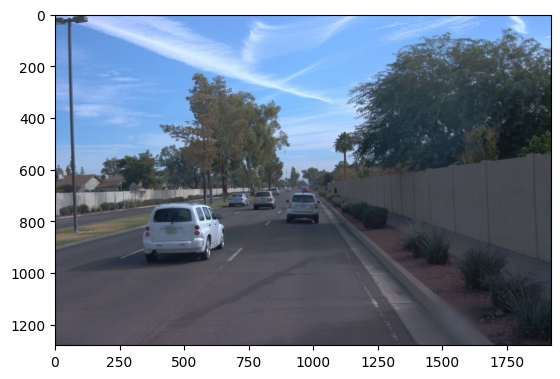

In [4]:
# Decode the image
img_array = dataset_tools.decode_img(camera)
# Plot the image using matplotlib
plt.figure()
plt.imshow(img_array)


##### Extract and plot detections

The <code>Camera</code> object contains a list of <code>CameraDetections</code>, which holds all the detections made by the camera. Each <code>CameraDetection</code> entry provides key details, including the type of object detected, the coordinates of its bounding box, and additional relevant metadata. Let's visualize these detections by plotting them on the image.

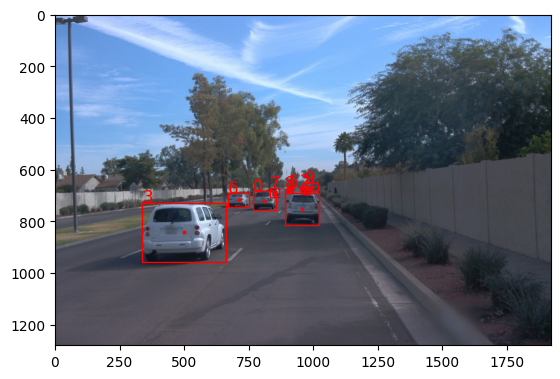

In [5]:
# Defining Color Labels for Detections

LABEL_COLOR_DICT = {
    0: (1.0, 0, 0), # Car red
    1: (0, 1.0, 0), # Truck green
    2: (0, 0, 1.0), # Pedestrian blue
    3: (0, 0.5, 0.5) # Cyclist
}

# Retrieve the list of detections from the camera object
camera_detections = camera.detections

# Show image
fig, ax = plt.subplots()
ax.imshow(img_array)

# Dictionary to transform from cameras ids to numeric ids 
ids_to_num = {}
i = 0

# We iterate through each detection
for detection in camera_detections:
    
    # Extract bbox parameters and
    # calculate the up-left corner
    x0, y0, width, height = detection.bbox
    x1 = x0 - height/2
    y1 = y0 - width/2

    # Assign a numeric id to the detection
    if ids_to_num.get(detection.id) is None:
        ids_to_num[detection.id] = i
        i += 1
    id = ids_to_num[detection.id]
    
    # Extract label and assign a color
    label = detection.type
    color = LABEL_COLOR_DICT[label]

    # Plot detection.
    r = patches.Rectangle((x1,y1),height, width, linewidth=1, edgecolor='r', facecolor='none')
    ax.scatter(x0, y0, color=color, s=3)
    ax.add_patch(r)
    ax.text(x1, y1, str(id), color=color, fontsize=12)
    
plt.show()


#### Lidar Data

##### Extract Lidar and Lidar Parameters

Similar than with the camera, the LIDAR data in each frame is encapsulated within a <code>Lidar</code> object, which provides details about the LIDAR that captured the pointcloud as well as the pointcloud itself. Each <code>Frame</code> has a list of <code>Lidar</code> objects that can be accessed by indexing. For this example we are only decoding The center Lidar of the vehicle. 

In [6]:
lidar = frame.lidars[0]

print(f"Timestamp: {lidar.timestamp}")
print(f"No of layers: {lidar.height}")
print(f"Points per layer: {lidar.width}")
print(f"No of channels: {lidar.channels}")

veh_to_lidar_mtx = np.asarray(lidar.T).reshape(4,4)

print("Vehicle to Lidar Transformation:")
display(Matrix(veh_to_lidar_mtx))


Timestamp: 1510593600.1401389
No of layers: 64
Points per layer: 3072
No of channels: 4
Vehicle to Lidar Transformation:


Matrix([
[  -0.852671921253204,    0.522445142269135, -0.00128078227862716,  1.22211813926697],
[  -0.522437870502472,   -0.852669239044189, -0.00372029235586524, 0.755211293697357],
[-0.00303573231212795, -0.00250305980443954,    0.999992251396179, -2.17964196205139],
[                   0,                    0,                    0,               1.0]])

##### decode pointcloud data

After exploring the structure and attributes of the lidar, let's proceed to decode the pointcloud from the Lidar. For this purpose, we utilize a function from <code>dataset_tools</code> named <code>decode_lidar</code>. This function decodes the pointcloud data from the lidar and returns it as a <code>numpy</code> array of shape (<code>lidar.width*lidar.height</code>,<code>lidar.channels</code>).

In [7]:
def show_pcl(pcl, boxes=None, ):
    """
    Displays a point cloud using Open3D with optional bounding boxes.

    Parameters:
    - pcl (np.array): A numpy array of shape (N, 3) where each row represents X, Y, Z coordinates of a point.
    - boxes (list of tuples, optional): A list where each tuple contains three numpy arrays (bbox_center, bbox_rot, bbox_size)
      representing the center, rotation matrix, and sizes of the bounding box, respectively.

    The function initializes a point cloud and visualizer, adds the point cloud to the visualizer,
    and optionally adds bounding boxes if they are provided and correctly formatted. Errors are printed
    for any incorrectly shaped inputs in the bounding box specifications.

    Returns:
    None
    """
    
    pointcloud = o3d.geometry.PointCloud()
    pointcloud.points = o3d.utility.Vector3dVector(pcl[:,:3])

    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(pointcloud)

    if boxes is not None:
        for box in boxes:
            bbox_center = box[0]
            bbox_rot = box[1]
            bbox_size = box[2]
            # # Check the shape of the box components
            if bbox_center.shape != (3,): 
                print("Error: Box center should be of shape (3,)")
                continue

            if bbox_rot.shape != (3,3): 
                print("Error: Box rotation should be a Rotation matrix of shape (3,3)")
                continue

            if bbox_size.shape != (3,): 
                print("Error: Box rot should be a Rotation matrix of shape (3,3)")
                continue
            
            bbox = o3d.geometry.OrientedBoundingBox(bbox_center, bbox_rot, bbox_size)
            bbox.color = (1,0,0)
            vis.add_geometry(bbox)

    opt = vis.get_render_option()
    opt.background_color = (0, 0, 0)
    opt.point_size = 2

    vis.run()
    vis.destroy_window()
    del opt  # Delete to avoid having  [Open3D ERROR] GLFW Error: The GLFW library is not initialized
    del vis  # Delete to avoid having  [Open3D ERROR] GLFW Error: The GLFW library is not initialized

In [8]:
# Extract pointcloud
pcl = dataset_tools.decode_lidar(lidar)
print(f"Pointcloud shape: {pcl.shape}")
show_pcl(pcl)  # comment if you dont have a running visualization
               # inside docker you have to care that you are forwarding the xserver.

Pointcloud shape: (196608, 4)


##### Extract and plot detections on pointcloud

The <code>Lidar</code> object contains a list of <code>LidarDetections</code>, which holds all the detections made by the camera. Each <code>LidarDetection</code> entry provides key details, including the type of object detected, the coordinates of the center of its bounding box, the rotation of the bounding box and the size. Let's visualize these detections by plotting them on a pointcloud.

In [9]:
# Extract lidar detections
detections = lidar.detections

# Placeholder to store the boxes
bboxes = []
ids = []
for detection in lidar.detections:
    # Extract bbox center (x,y,z )
    bbox_center = np.array(detection.pos)
    # Extract bbox orientation (roll, pitch, yaw)
    bbox_rot = np.array(detection.rot)
    # Extract bbox size (x, y, z)
    bbox_size = np.array(detection.scale)
    label = detection.type
    # Get color for bounding box
    color = LABEL_COLOR_DICT[label]
    
    # Convert IDs to numbers    
    if ids_to_num.get(detection.id) is None:
        ids_to_num[detection.id] = i
        i+=1

    id = ids_to_num[detection.id]

    # Convert Detection orientation from Euler angles to matrix   
    R = Rotation.from_euler('xyz', bbox_rot).as_matrix()

    # Append boxes
    bboxes.append([bbox_center, R, bbox_size, id])

# Plot boxes the core of plotting them relies on the function
# o3d.geometry.OrientedBoundingBox(bbox_center, bbox_rot, bbox_size)

show_pcl(pcl, bboxes) # comment if you dont have a running visualization
                      # inside docker you have to care that you are forwarding the xserver.

#### Project coordinates to image

In our lesson, we examined the pinhole camera model. As a refresher, consider the following image:

![image_1](https://github.com/leggedrobotics/darknet_ros/assets/27258035/a5300b02-a4e7-4cf4-a89b-c9be3f157567)

Based on this, we can calculate the coordinates of a point  $(p_x, p_y, p_z)$ in image coordinates using the following formula:

$$
x_{img} = c_x - f_x\frac{p_y}{p_x} \\
y_{img} = c_y - f_y\frac{p_z}{p_x}
$$

Here, $f_x$ and $c_x$ denote the focal length and the principal point coordinates of the camera along the x-axis, respectively. Similarly, $f_y$ and $c_y$ represent the focal length and the principal point coordinates along the y-axis

These equations assume that the coordinate system matches the one depicted in the image above. However, in the dataset, transformation matrices convert points to the camera's reference system, as illustrated in the subsequent image:


![image_2](https://github.com/leggedrobotics/darknet_ros/assets/27258035/93220364-3284-4815-9761-a2b161132984)


With this in mind, there has to be a slight modification on the equations above as after transformaiton the depth is the z axis and the x the horizontal axis. Also see that y axis is inverted, therefore the image is:

$$
x_{img} = c_x + f_x \frac{p_x}{p_z} \\ \\
y_{img} = c_y + f_y \frac{p_y}{p_z}
$$

Let's explore how to convert these coordinates using our dataset, aiming to plot the centers of boxes from the LiDAR perspective to the camera perspective.

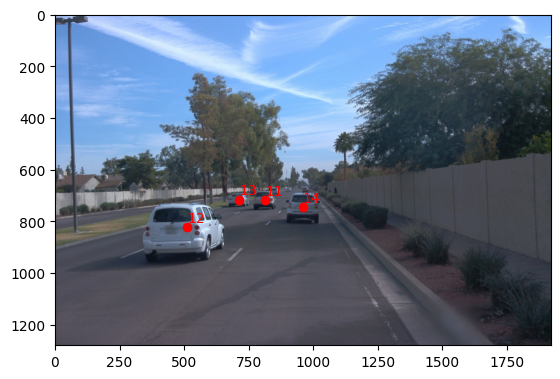

In [10]:
plt.figure()
plt.imshow(img_array)
for box in bboxes:

    box_center = box[0]
    box_rot_mtx = box[1]
    box_size = box[2]
    id = box[3]

    # Filter boxes that are behind the vehicle
    if box_center[0] < 0 or box_center[0] > 100:
        continue

    box_center = np.asarray([box_center])

    # Transform to homogeneous coordinates [x,y,z,1]
    center_3d_homogeneous = np.ones((box_center.shape[0], box_center.shape[1]+1))
    center_3d_homogeneous[:,:3] = box_center
    
    # Transform the from lidar perspective to camera perspective
    transformed_center = (veh_to_camera_mtx@center_3d_homogeneous.T).T
    transformed_center = transformed_center[:,:3]
    
    # Extract depth information
    depth = transformed_center[:,-1:]

    # Scale corners in 3D
    # px' = px/pz, py' = py/pz
    # [px, py, pz] -> [px/pz, py/pz, 1] 
    scaled_corners_3D = transformed_center / depth
    
    # Transform to image perspective
    corners_2D = (camera_intrinsic_mtx@scaled_corners_3D.T).T
    corners_2D[:,-1] = depth
    
    plt.scatter(corners_2D[:,0], corners_2D[:,1], color='r')
    plt.text(corners_2D[:,0], corners_2D[:,1]-20, id,  color='r', fontsize=10)

### Example of using the frame to create tracks

Now let's explify how to initilize the tracks and how to plot them using the lidar data

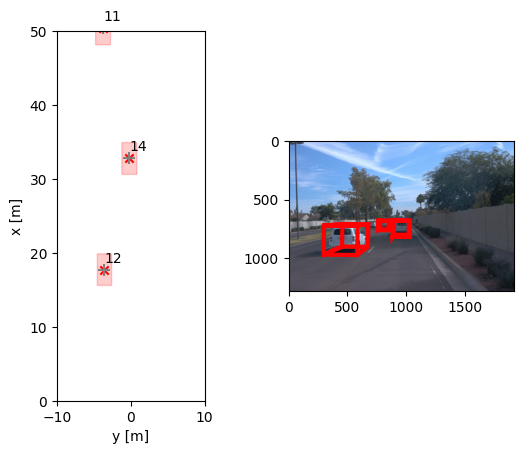

In [11]:
class Track:
    
    def __init__(self, detection):
        self.x = np.asarray(detection.pos)
        self.l = detection.scale[0]
        self.w = detection.scale[1]
        self.h = detection.scale[2]
        self.yaw = detection.rot[2]
        self.state = "initialized"
        # Convert IDs to numbers    
        if ids_to_num.get(detection.id) is None:
            ids_to_num[detection.id] = i
            i+=1

        self.id = ids_to_num[detection.id]

tracks = [Track(detection) for detection in lidar.detections if detection.pos[0]>0 and detection.pos[0]<55]

plot_tools.plot_tracks(img_array,tracks,[], lidar.detections, camera)